In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit as sigmoid

from time import time
from time import sleep

In [2]:
#function to do nothing -- helps clean code use din debugging
def silent(a = None):
    return

def shuffle_together(v_1, v_2):
    assert len(v_1) == len(v_2), "vectors different length"
    
    perm = np.random.permutation(len(v_1))
    return v_1[perm], v_2[perm]


In [3]:
class connected_layer:
    def __init__(self, num_neurons, prev_neurons):
        
        #number of neurons in layer and previous layer
        self.size = num_neurons 
        self.prev_size = prev_neurons 
        
        #weight matrix and bias matrix initialization
        
        #-must randomize weight matrix so that gradient isn't same for all neurons
        #--because gradient of neuron w respect to previous neuron is just associated weight
        self.weight_mat = np.random.uniform(-1, 1, (num_neurons, prev_neurons))
        self.weight_mat_update = np.zeros((num_neurons, prev_neurons))
        
        
        #-want to be column vector
        #--no reason to not initialize to 0
        self.bias_mat = np.zeros((num_neurons, 1))
        self.bias_mat_update = np.zeros((num_neurons, 1))
        
    
    
    #pushes sample through layer and remembers output
    #also calcualtes gradient to previous layer
    def forward(self, activations):
        self.out = self.weight_mat @ activations + self.bias_mat
        
        self.gradient_to_prev = self.gradient()
        
        return self.out

    
    #returns gradient of layer output (vector)  with respect to weights (matrix)
    #loose definition check notes for how this is defined
    def gradient(self):
        return self.weight_mat.T

    
class activation_layer:
    def __init__(self, size):
        self.size = size
        self.prev_size = size
    
    #gradient of output with respect to input
    #will always be diagonal matrix since layer is not "fully" connected
    def gradient(self):
        return np.diag(self.out.flatten()*(1-self.out.flatten()))
    
    #pushes sample through layer and remembers output
    #also calcualtes gradient to previous layer
    def forward(self, x):
        assert x.shape == (self.size, 1), f"input and layer size incompatible, {x.shape} passed"
        
        self.out = sigmoid(x)
        self.gradient_to_prev = self.gradient()
        
        return self.out
    
    
    
class input_layer:
    def __init__(self, size):
        self.size = size
        self.prev_size = None
        self.gradient_to_prev = None
        
    def gradient(self):
        return None
    
    #feeds sample to first fully connected layer
    def forward(self, x):
        assert len(x) == self.size, "input incorrect length" 
        
        self.out = x
        
        return x
        
        

In [4]:
#Creating NN object

class network:
    def __init__(self, layers):
        self.layers = layers
        self.num_layers = len(layers)
        
        #input size = number of weights associated w/ each neuron in first layer
        self.input_size = layers[0].size
        self.output_size = layers[-1].size
        
        self.epochs_trained = 0
        self.loss_history = np.empty(0)
        self.train_time = 0
        
        self.verify()
    
    def reset_update_mats(self):
        for layer in self.layers:
            if type(layer) == connected_layer:
                layer.weight_mat_update = abs(layer.weight_mat_update*0)
                layer.bias_mat_update = abs(layer.bias_mat_update*0)
                
    def loss(self, x, y):
        assert x.shape[0] == y.shape[0], "x and y incompatible shapes"
        
        squared_error = 0
        for i in range(len(x)):
            squared_error += sum((self.predict(x[i]).flatten() - y[i])**2)
        
        return squared_error/len(y.flatten())
    
    def graph_loss_history(self):
        
        plt.figure(figsize = (7,4))
        plt.style.use("ggplot")
        plt.plot(np.arange(self.epochs_trained), self.loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")

        y_range = max(self.loss_history) - min(self.loss_history)

        plt.text(self.epochs_trained*.7, y_range*.95 + min(self.loss_history),
                 f"ms/epoch: {round(self.train_time/self.epochs_trained*1000,3)}",
                 color = "darkgreen",)
        
        plt.text(self.epochs_trained*.7, y_range*.85 + min(self.loss_history),
                 f" train loss: {round(self.train_loss,4)}",
                 color = "darkgreen",)
        
        plt.show()
                
        
    def verify(self):
        for i in range(1,len(self.layers)):
            assert self.layers[i-1].size == self.layers[i].prev_size, "invalid network"
            
            
    def verify_sample(self, x, y):
        assert len(x) == len(y), "x and y havent different numebr of samples"
        
        for i in range(len(x)):
            assert len(x[i]) == self.input_size, f"sample at index [{i}] incorrect input size"
            assert len(y[i]) == self.output_size, f"sample at index [{i}] incorrect output size"
        
        
    def predict(self, inp):
        inp = inp.reshape(self.input_size,1)
        assert inp.shape == (self.input_size, 1), "wrong input size"
        
        for i in range(self.num_layers):

            inp = self.layers[i].forward(inp)
            
        return inp
    
    
    def print_structure(self):
        for i,layer in enumerate(self.layers[::-1]):
            print("-"*45)
            print(type(layer))
            print(f"  layer: {self.num_layers-i-1}/{self.num_layers-1}")
            print(f"neurons: {layer.size}")
            print(f" prev n: {layer.prev_size}")
            print()
   
        
    def forward(self, x):
        assert x.shape == (self.input_size,1)
        
        for layer in self.layers:
            x = layer.forward(x)
            
            
    def backward(self, y, learn_coef = 1):
        
        g_cost_layer = np.array([2*(self.layers[-1].out[i] - y[i]) for i in range(self.output_size)])
        
        
        #Looping through layers: going from end --> start 
        
        i = len(self.layers)-1
        
        while i>0:
             
            #if it's a connected layer we want to update its weights and biases
            if type(self.layers[i]) == connected_layer:
                
                #updating weights

                g_layer_weights = np.array([self.layers[i-1].out.flatten() for c in range(self.layers[i].size)])
                
                g_cost_weights = np.diag(g_cost_layer.flatten()) @ g_layer_weights
                
            
                self.layers[i].weight_mat_update = self.layers[i].weight_mat_update - (g_cost_weights*learn_coef)
                
                
                #updating biasses
                
                g_cost_bias = g_cost_layer
                
                self.layers[i].bias_mat_update = self.layers[i].bias_mat_update - (g_cost_bias*learn_coef)
                
            
            g_cost_layer = self.layers[i].gradient_to_prev @ g_cost_layer
            
            
            i -= 1
        
        
    def fit(self, x, y, epochs = 10, learn_coef = .1, verbose = True):
        
        
        loss_history = np.zeros(epochs)

        start_time = time()
        for epoch in range(epochs):

            for s in range(len(x)):
                self.forward(x[s].reshape(-1,1))
                self.backward(y[s].reshape(-1,1), learn_coef)

            for layer in self.layers: 
                if type(layer) == connected_layer:
                    layer.weight_mat = layer.weight_mat + (layer.weight_mat_update/len(x))
                    layer.bias_mat = layer.bias_mat + (layer.bias_mat_update/len(x))

            self.reset_update_mats()

            loss = self.loss(x, y)
            loss_history[epoch] = loss
            self.epochs_trained += 1

            if (verbose) and (epoch%(epochs/5) == 0):
                print("-"*20)     
                print(f"epoch: {self.epochs_trained} \n loss: {round(loss, 4)}")
                
            

        self.train_time += time() - start_time
        self.train_loss = self.loss(x, y)
        if verbose:
            print("-"*20 + f"\nepoch: done \n loss: {round(self.loss(x, y), 4)}")

        
        
        self.loss_history = np.concatenate((self.loss_history, loss_history))
        
        
            

#### Creating network with 2 hidden layers containg 10 neurons each all with sigmoid activations

In [5]:
np.random.seed(10)

test_net_layers = [
    input_layer(size = 2),
    
    connected_layer(num_neurons = 10, prev_neurons = 2),
    activation_layer(10),
    
    connected_layer(num_neurons = 10, prev_neurons = 10),
    activation_layer(10),
    
    connected_layer(num_neurons = 2, prev_neurons = 10)
    
]

test_net = network(test_net_layers)

#### Creating data points to lean

True Relationship :  $\hspace{4mm} F(x, y) = (x \cdot y, x + y)$

In [6]:
x = np.random.uniform(-2,2,(1000,2))

y = np.array([[s[0]*s[1], s[0] + s[1]] for s in x])


#### Training on 500 epochs using regular gradient decent

In [7]:
test_net.fit(x, y, epochs = 500)

--------------------
epoch: 1 
 loss: 2.2657
--------------------
epoch: 101 
 loss: 0.8998
--------------------
epoch: 201 
 loss: 0.5018
--------------------
epoch: 301 
 loss: 0.1719
--------------------
epoch: 401 
 loss: 0.1103
--------------------
epoch: done 
 loss: 0.0827


#### Visualizing training loss

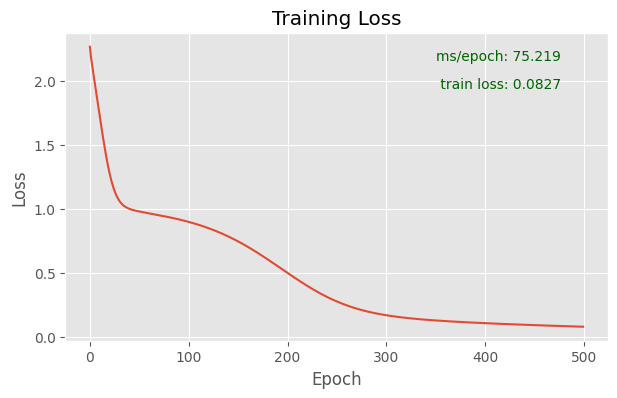

In [8]:
test_net.graph_loss_history()

#### Testing out of sample data points

In [9]:
x_test = np.random.uniform(-2,2,(10000,2))

y_test = np.array([[s[0]*s[1], s[0] + s[1]] for s in x_test])
    
test_net.loss(x_test, y_test)

0.084297158876774

In [10]:
for i in range(4):
    print("-"*45)    
    print("in, out:\n", x_test[i].round(2), ",", y_test[i].round(2), 
          "\n\npredicted:\n", test_net.predict(x_test[i]).flatten().round(2))

---------------------------------------------
in, out:
 [ 0.85 -1.68] , [-1.43 -0.82] 

predicted:
 [-1.34 -0.61]
---------------------------------------------
in, out:
 [-1.04  1.09] , [-1.13  0.05] 

predicted:
 [-1.33  0.05]
---------------------------------------------
in, out:
 [-0.17 -1.58] , [ 0.27 -1.75] 

predicted:
 [ 0.32 -1.7 ]
---------------------------------------------
in, out:
 [-0.9  -0.81] , [ 0.73 -1.71] 

predicted:
 [ 1.   -1.96]
